# Automated fitting of SPEIS data from any MPT file acquired _via_ EC-lab

Load the given file in the current directory

In [1]:
%load_ext jupyternotify
from impedance import preprocessing
filename = 'SnO2_bare_4_sac_EIS_light_1sun_20mVScans'
# Load data from the BioLabs MPT file
frequencies, Z = preprocessing.readBioLogic("./" + filename + ".mpt")
# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

<IPython.core.display.Javascript object>

## Measurement parameters

In [2]:
# Ask for the potential start and steps of the potential measurement
print("What was the initial potential in mV?")
pot_start = int(input())
print("What was the potential step in mV?")
pot_step = int(input())
print("What was the pH of the solution?")
pot_pH = float(input())

What was the initial potential in mV?
-500
What was the potential step in mV?
20
What was the pH of the solution?
9


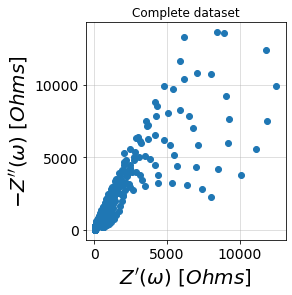

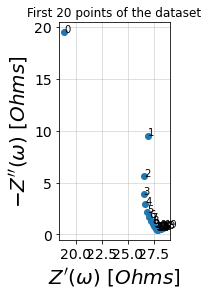

In [3]:
# Get an overview over the whole dataset
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist

fig, ax = plt.subplots()
plot_nyquist(ax, Z, fmt='o')
plt.title("Complete dataset")
plt.ion()
plt.show()

# First number of points to show
cutoff_start = 20
cutoff_end = 2

# Plot subrange
fig, ax = plt.subplots()
plot_nyquist(ax, Z[:cutoff_start], fmt='o')
for i in range(cutoff_start):
    ax.annotate(i, (Z[i].real, -Z[i].imag))
plt.title("First " + str(cutoff_start) + " points of the dataset")
plt.show()

In [4]:
# split dataset into individual measurements separated by the initial measurement frequeny frequencies[0]
import numpy as np
potstepnumber = np.count_nonzero(frequencies == frequencies[0])
frequencies = np.array_split(frequencies, potstepnumber)
Z = np.array_split(Z, potstepnumber)

# generate list with potentials vs. Ag/AgCl for each measurement
potentials_Ag = [(x)*pot_step+pot_start for x in range(potstepnumber)]

In [5]:
#Initialize all implemented circuit models

from impedance.models.circuits import CustomCircuit

#Load Circuit with one parallel RC element
oneRC_string = 'R0-p(R1,C1)'
initial_guess_oneRC = [30, 100, 1E-5]
bounds_oneRC = [[20, 1E+2, 1E-9], [50, 1E+5, 1E-2]]

oneRC = CustomCircuit(oneRC_string, initial_guess=initial_guess_oneRC)

#Load Circuit with one parallel RCPE element
oneRCPE_string = 'R0-p(R1,CPE1)'
parameters1rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P"]
initial_guess_oneRCPE = [30, 1E+3, 1E-5, 1]
bounds_oneRCPE = [[20, 1E+2, 1E-9, 0.8], [50, 1E+5, 1E-2, 1]]

oneRCPE = CustomCircuit(oneRCPE_string, initial_guess=initial_guess_oneRCPE)

#Load Circuit with two parallel RCPE elements
twoRCPE_string = 'R0-p(R1,CPE1)-p(R2,CPE2)'
parameters2rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P", "R_2", "CPE_2-T", "CPE_2-P"]
initial_guess_twoRCPE = [30, 1E+3, 1E-5, 1, 1E+2, 1E-6, 1]
bounds_twoRCPE = [[20, 1E+2, 1E-9, 0.4, 1E+2, 1E-9, 0.8], [50, 1E+5, 1E-2, 1, 1E+6, 1E-2, 1]]

twoRCPE = CustomCircuit(twoRCPE_string, initial_guess=initial_guess_twoRCPE)

## Selection of cycles to analyze

In [6]:
from impedance.visualization import plot_altair
import altair as alt

dicts = {}
for step in range(0,potstepnumber):
    dicts[str(step*pot_step+pot_start) + "mV"] = {'f': frequencies[step], 'Z': Z[step]}
plot_altair(dicts)

alt.HConcatChart(...)

In [7]:
print("There are " + str(potstepnumber) + " cycles in total.")
print("With which cycle number do you want to start your analysis?")
cycle_start = int(input())-1
print("With which cycle number do you want to end your analysis?")
cycle_end = int(input())-1

There are 51 cycles in total.
With which cycle number do you want to start your analysis?
1
With which cycle number do you want to end your analysis?
51


## Selection of fitting model

In [8]:
print("Which model do you want to use? (1RC, 1RCPE or 2RCPE)")
model = input()

if model == "1RC":
    results = [initial_guess_oneRC]
    model_circuit_bounds = bounds_oneRC
    model_circuit = oneRC
elif model == "1RCPE":
    results = [initial_guess_oneRCPE]
    model_circuit = oneRCPE
    model_circuit_bounds = bounds_oneRCPE
elif model == "2RCPE":
    results = [initial_guess_twoRCPE]
    model_circuit = twoRCPE
    model_circuit_bounds = bounds_twoRCPE
else:
    print("Eingabe ungültig")

Which model do you want to use? (1RC, 1RCPE or 2RCPE)
2RCPE


<IPython.core.display.Javascript object>

Result of Cycle 0:


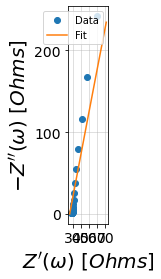

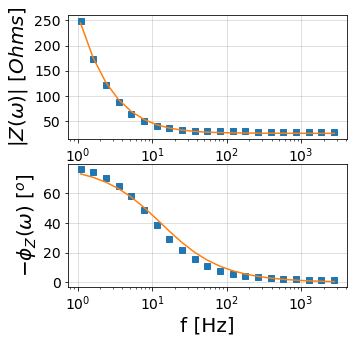


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.64e+01  (+/- 2.80e+00) [Ohm]
     R1 = 6.08e+04  (+/- 4.86e+08) [Ohm]
  CPE1_0 = 1.32e-03  (+/- 1.78e+01) [Ohm^-1 sec^a]
  CPE1_1 = 8.66e-01  (+/- 2.48e+02) []
     R2 = 1.79e+04  (+/- 3.30e+08) [Ohm]
  CPE2_0 = 1.82e-03  (+/- 3.40e+01) [Ohm^-1 sec^a]
  CPE2_1 = 9.06e-01  (+/- 4.24e+02) []

Fitting error of parameter #0 at 10.6%
Fitting error of parameter #1 at 798974.0%
Fitting error of parameter #2 at 1352437.6%
Fitting error of parameter #3 at 28600.9%
Fitting error of parameter #4 at 1848872.8%
Fitting error of parameter #5 at 1868671.2%
Fitting error of parameter #6 at 46795.3%


Result of Cycle 1:


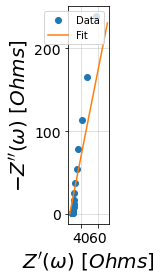

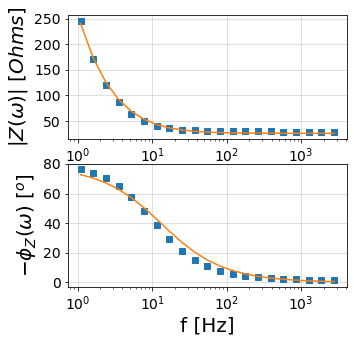


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.60e+01  (+/- 3.12e+00) [Ohm]
     R1 = 6.17e+04  (+/- 6.48e+08) [Ohm]
  CPE1_0 = 1.44e-03  (+/- 9.27e+00) [Ohm^-1 sec^a]
  CPE1_1 = 8.55e-01  (+/- 1.54e+02) []
     R2 = 1.78e+04  (+/- 1.15e+08) [Ohm]
  CPE2_0 = 1.71e-03  (+/- 1.31e+01) [Ohm^-1 sec^a]
  CPE2_1 = 9.09e-01  (+/- 2.43e+02) []

Fitting error of parameter #0 at 12.0%
Fitting error of parameter #1 at 1049250.7%
Fitting error of parameter #2 at 644920.4%
Fitting error of parameter #3 at 17964.8%
Fitting error of parameter #4 at 644040.3%
Fitting error of parameter #5 at 764102.0%
Fitting error of parameter #6 at 26693.5%


Result of Cycle 2:


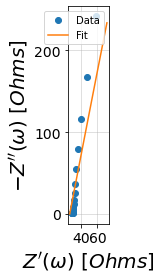

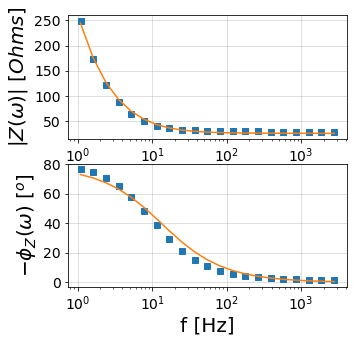


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.60e+01  (+/- 3.10e+00) [Ohm]
     R1 = 6.15e+04  (+/- 5.93e+08) [Ohm]
  CPE1_0 = 1.38e-03  (+/- 1.03e+01) [Ohm^-1 sec^a]
  CPE1_1 = 8.58e-01  (+/- 1.68e+02) []
     R2 = 1.79e+04  (+/- 1.46e+08) [Ohm]
  CPE2_0 = 1.73e-03  (+/- 1.60e+01) [Ohm^-1 sec^a]
  CPE2_1 = 9.09e-01  (+/- 2.75e+02) []

Fitting error of parameter #0 at 11.9%
Fitting error of parameter #1 at 964061.3%
Fitting error of parameter #2 at 744560.4%
Fitting error of parameter #3 at 19614.8%
Fitting error of parameter #4 at 812044.6%
Fitting error of parameter #5 at 926128.2%
Fitting error of parameter #6 at 30190.2%


Result of Cycle 3:


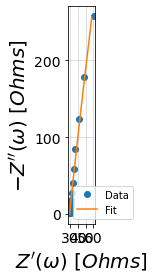

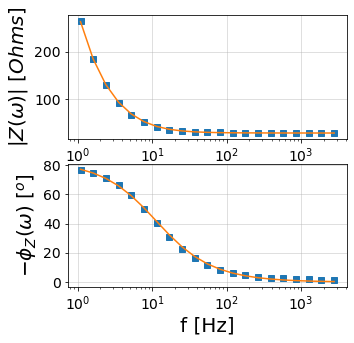


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.92e+01  (+/- 2.56e-01) [Ohm]
     R1 = 1.83e+04  (+/- 1.22e+07) [Ohm]
  CPE1_0 = 8.15e-04  (+/- 2.73e-01) [Ohm^-1 sec^a]
  CPE1_1 = 9.34e-01  (+/- 2.44e+00) []
     R2 = 2.87e+05  (+/- 1.19e+04) [Ohm]
  CPE2_0 = 2.96e-03  (+/- 3.60e+00) [Ohm^-1 sec^a]
  CPE2_1 = 9.34e-01  (+/- 8.82e+00) []

Fitting error of parameter #1 at 66507.0%
Fitting error of parameter #2 at 33516.1%
Fitting error of parameter #3 at 260.8%
Fitting error of parameter #5 at 121560.4%
Fitting error of parameter #6 at 944.5%


Result of Cycle 4:


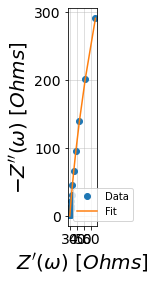

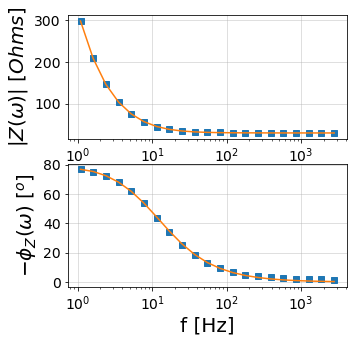


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.95e+01  (+/- 1.37e-01) [Ohm]
     R1 = 1.00e+05  (+/- 1.83e+07) [Ohm]
  CPE1_0 = 6.92e-04  (+/- 2.66e-03) [Ohm^-1 sec^a]
  CPE1_1 = 9.39e-01  (+/- 9.73e-02) []
     R2 = 2.27e+02  (+/- 5.11e+03) [Ohm]
  CPE2_0 = 2.45e-03  (+/- 3.33e-02) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 5.28e-01) []

Fitting error of parameter #1 at 18289.1%
Fitting error of parameter #2 at 385.1%
Fitting error of parameter #3 at 10.4%
Fitting error of parameter #4 at 2248.9%
Fitting error of parameter #5 at 1360.2%
Fitting error of parameter #6 at 52.8%


Result of Cycle 5:


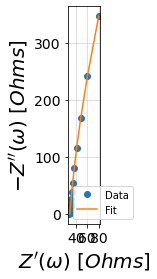

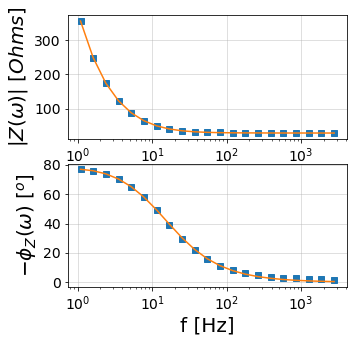


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.94e+01  (+/- 1.70e-01) [Ohm]
     R1 = 8.20e+03  (+/- 1.03e+04) [Ohm]
  CPE1_0 = 5.31e-04  (+/- 1.92e-04) [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00  (+/- 7.93e-02) []
     R2 = 2.88e+02  (+/- 5.72e+02) [Ohm]
  CPE2_0 = 2.04e-03  (+/- 2.21e-03) [Ohm^-1 sec^a]
  CPE2_1 = 8.55e-01  (+/- 1.04e-01) []

Fitting error of parameter #1 at 126.2%
Fitting error of parameter #2 at 36.1%
Fitting error of parameter #4 at 198.5%
Fitting error of parameter #5 at 108.3%
Fitting error of parameter #6 at 12.2%


Result of Cycle 6:


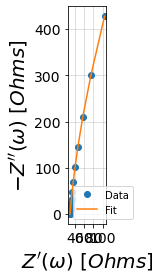

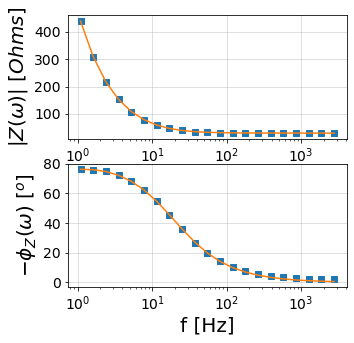


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.94e+01  (+/- 1.64e-01) [Ohm]
     R1 = 1.48e+04  (+/- 3.74e+04) [Ohm]
  CPE1_0 = 5.05e-04  (+/- 1.91e-04) [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00  (+/- 8.42e-02) []
     R2 = 5.60e+02  (+/- 6.41e+02) [Ohm]
  CPE2_0 = 1.06e-03  (+/- 7.17e-04) [Ohm^-1 sec^a]
  CPE2_1 = 8.84e-01  (+/- 6.99e-02) []

Fitting error of parameter #1 at 253.3%
Fitting error of parameter #2 at 37.8%
Fitting error of parameter #4 at 114.5%
Fitting error of parameter #5 at 67.4%


Result of Cycle 7:


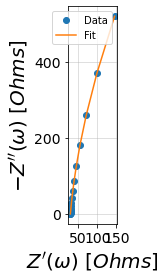

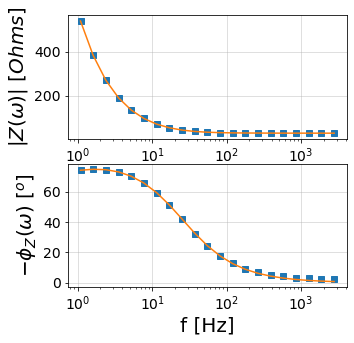


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.92e+01  (+/- 1.55e-01) [Ohm]
     R1 = 6.99e+02  (+/- 3.75e+02) [Ohm]
  CPE1_0 = 6.89e-04  (+/- 2.37e-04) [Ohm^-1 sec^a]
  CPE1_1 = 8.96e-01  (+/- 4.22e-02) []
     R2 = 1.44e+04  (+/- 2.19e+04) [Ohm]
  CPE2_0 = 4.58e-04  (+/- 8.74e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 9.49e-02) []

Fitting error of parameter #1 at 53.5%
Fitting error of parameter #2 at 34.5%
Fitting error of parameter #4 at 151.5%
Fitting error of parameter #5 at 19.1%


Result of Cycle 8:


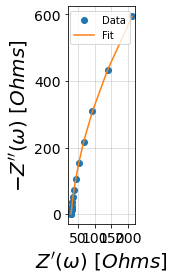

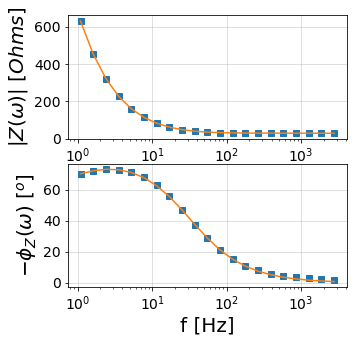


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.90e+01  (+/- 1.10e-01) [Ohm]
     R1 = 5.74e+03  (+/- 9.46e+02) [Ohm]
  CPE1_0 = 3.43e-04  (+/- 4.14e-05) [Ohm^-1 sec^a]
  CPE1_1 = 9.27e-01  (+/- 9.89e-03) []
     R2 = 2.75e+02  (+/- 1.66e+02) [Ohm]
  CPE2_0 = 8.21e-04  (+/- 2.46e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.71e-01  (+/- 3.63e-02) []

Fitting error of parameter #1 at 16.5%
Fitting error of parameter #2 at 12.1%
Fitting error of parameter #4 at 60.2%
Fitting error of parameter #5 at 29.9%


Result of Cycle 9:


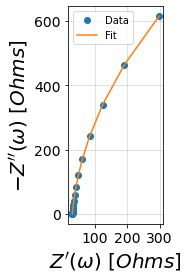

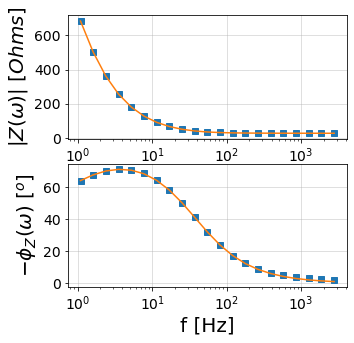


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.88e+01  (+/- 1.43e-01) [Ohm]
     R1 = 2.63e+03  (+/- 1.14e+03) [Ohm]
  CPE1_0 = 4.79e-04  (+/- 1.41e-04) [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00  (+/- 1.84e-01) []
     R2 = 7.97e+02  (+/- 5.30e+02) [Ohm]
  CPE2_0 = 3.51e-04  (+/- 1.50e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.17e-01  (+/- 3.55e-02) []

Fitting error of parameter #1 at 43.4%
Fitting error of parameter #2 at 29.4%
Fitting error of parameter #3 at 18.4%
Fitting error of parameter #4 at 66.4%
Fitting error of parameter #5 at 42.6%


Result of Cycle 10:


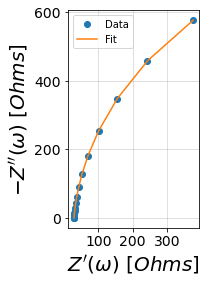

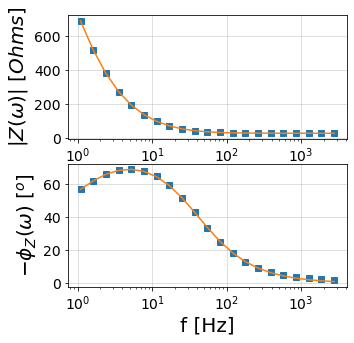


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.87e+01  (+/- 1.39e-01) [Ohm]
     R1 = 1.23e+03  (+/- 8.94e+02) [Ohm]
  CPE1_0 = 5.03e-04  (+/- 3.10e-04) [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00  (+/- 2.49e-01) []
     R2 = 6.97e+02  (+/- 6.25e+02) [Ohm]
  CPE2_0 = 2.99e-04  (+/- 1.78e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.23e-01  (+/- 3.58e-02) []

Fitting error of parameter #1 at 72.6%
Fitting error of parameter #2 at 61.6%
Fitting error of parameter #3 at 24.9%
Fitting error of parameter #4 at 89.7%
Fitting error of parameter #5 at 59.4%


Result of Cycle 11:


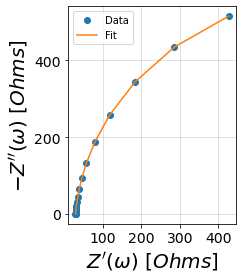

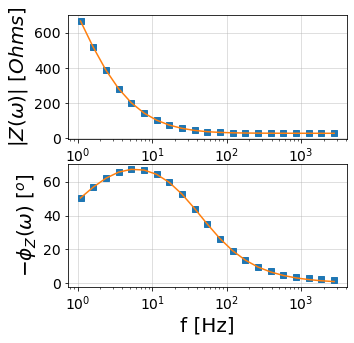


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.86e+01  (+/- 1.37e-01) [Ohm]
     R1 = 7.33e+02  (+/- 1.08e+03) [Ohm]
  CPE1_0 = 6.56e-04  (+/- 8.74e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.98e-01  (+/- 4.55e-01) []
     R2 = 6.93e+02  (+/- 8.23e+02) [Ohm]
  CPE2_0 = 2.48e-04  (+/- 1.91e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.32e-01  (+/- 4.76e-02) []

Fitting error of parameter #1 at 147.3%
Fitting error of parameter #2 at 133.2%
Fitting error of parameter #3 at 45.6%
Fitting error of parameter #4 at 118.7%
Fitting error of parameter #5 at 76.8%


Result of Cycle 12:


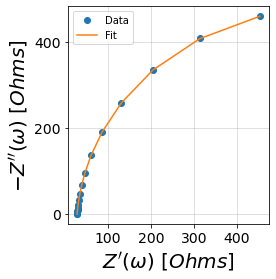

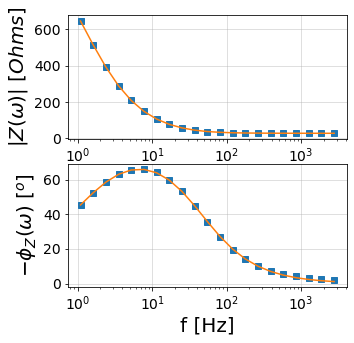


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.86e+01  (+/- 9.11e-02) [Ohm]
     R1 = 5.35e+02  (+/- 8.26e+02) [Ohm]
  CPE1_0 = 6.91e-04  (+/- 1.08e-03) [Ohm^-1 sec^a]
  CPE1_1 = 9.85e-01  (+/- 3.86e-01) []
     R2 = 6.17e+02  (+/- 6.93e+02) [Ohm]
  CPE2_0 = 2.32e-04  (+/- 1.65e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.37e-01  (+/- 4.54e-02) []

Fitting error of parameter #1 at 154.3%
Fitting error of parameter #2 at 155.8%
Fitting error of parameter #3 at 39.2%
Fitting error of parameter #4 at 112.2%
Fitting error of parameter #5 at 71.2%


Result of Cycle 13:


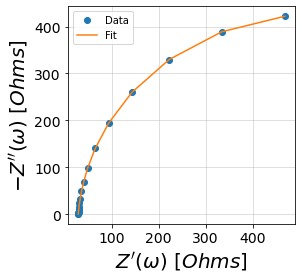

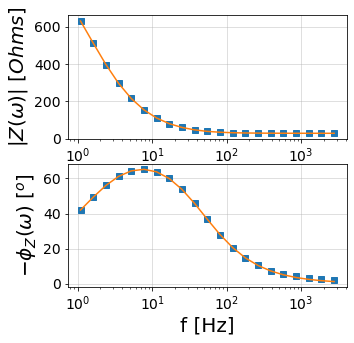


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.85e+01  (+/- 7.22e-02) [Ohm]
     R1 = 4.13e+02  (+/- 4.63e+02) [Ohm]
  CPE1_0 = 8.66e-04  (+/- 9.34e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.86e-01  (+/- 3.04e-01) []
     R2 = 6.25e+02  (+/- 3.78e+02) [Ohm]
  CPE2_0 = 2.08e-04  (+/- 7.70e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.40e-01  (+/- 2.74e-02) []

Fitting error of parameter #1 at 112.1%
Fitting error of parameter #2 at 107.8%
Fitting error of parameter #3 at 30.9%
Fitting error of parameter #4 at 60.4%
Fitting error of parameter #5 at 37.0%


Result of Cycle 14:


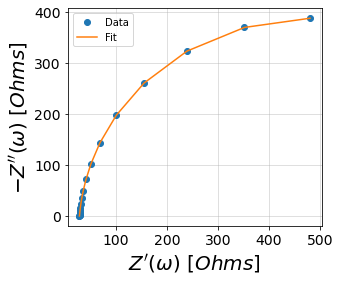

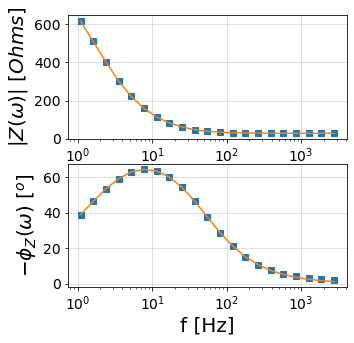


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.85e+01  (+/- 7.12e-02) [Ohm]
     R1 = 3.49e+02  (+/- 3.14e+02) [Ohm]
  CPE1_0 = 8.98e-04  (+/- 8.07e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.78e-01  (+/- 2.24e-01) []
     R2 = 5.88e+02  (+/- 2.65e+02) [Ohm]
  CPE2_0 = 1.97e-04  (+/- 5.33e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.42e-01  (+/- 2.11e-02) []

Fitting error of parameter #1 at 90.0%
Fitting error of parameter #2 at 89.9%
Fitting error of parameter #3 at 22.9%
Fitting error of parameter #4 at 45.0%
Fitting error of parameter #5 at 27.1%


Result of Cycle 15:


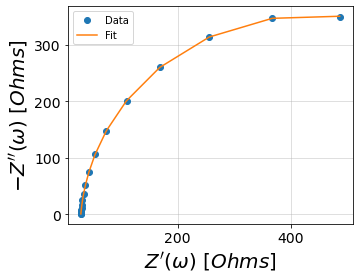

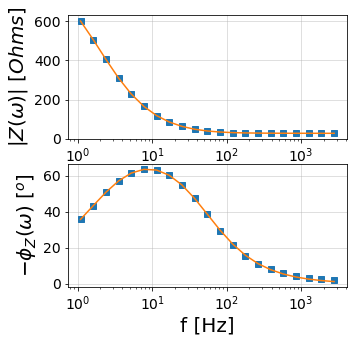


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.84e+01  (+/- 8.95e-02) [Ohm]
     R1 = 2.90e+02  (+/- 2.71e+02) [Ohm]
  CPE1_0 = 9.64e-04  (+/- 9.44e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.67e-01  (+/- 2.09e-01) []
     R2 = 5.58e+02  (+/- 2.35e+02) [Ohm]
  CPE2_0 = 1.86e-04  (+/- 4.61e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.43e-01  (+/- 2.12e-02) []

Fitting error of parameter #1 at 93.3%
Fitting error of parameter #2 at 97.9%
Fitting error of parameter #3 at 21.6%
Fitting error of parameter #4 at 42.2%
Fitting error of parameter #5 at 24.8%


Result of Cycle 16:


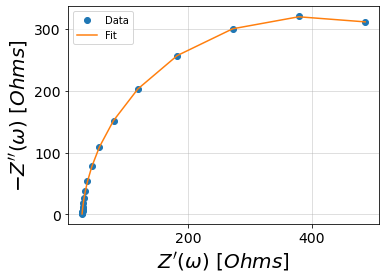

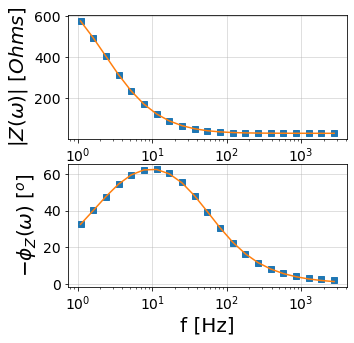


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.83e+01  (+/- 9.90e-02) [Ohm]
     R1 = 2.58e+02  (+/- 1.80e+02) [Ohm]
  CPE1_0 = 9.72e-04  (+/- 7.52e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.51e-01  (+/- 1.39e-01) []
     R2 = 5.11e+02  (+/- 1.61e+02) [Ohm]
  CPE2_0 = 1.77e-04  (+/- 3.12e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.46e-01  (+/- 1.78e-02) []

Fitting error of parameter #1 at 69.7%
Fitting error of parameter #2 at 77.4%
Fitting error of parameter #3 at 14.6%
Fitting error of parameter #4 at 31.4%
Fitting error of parameter #5 at 17.6%


Result of Cycle 17:


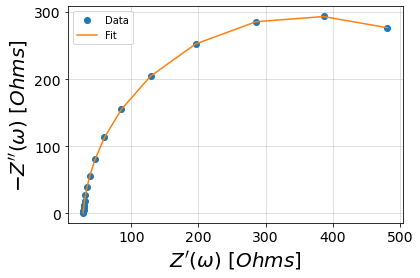

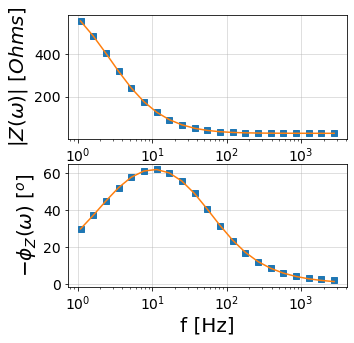


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.83e+01  (+/- 9.93e-02) [Ohm]
     R1 = 2.03e+02  (+/- 1.37e+02) [Ohm]
  CPE1_0 = 1.26e-03  (+/- 8.83e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.48e-01  (+/- 1.60e-01) []
     R2 = 5.07e+02  (+/- 1.18e+02) [Ohm]
  CPE2_0 = 1.63e-04  (+/- 1.98e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.45e-01  (+/- 1.49e-02) []

Fitting error of parameter #1 at 67.4%
Fitting error of parameter #2 at 70.2%
Fitting error of parameter #3 at 16.9%
Fitting error of parameter #4 at 23.2%
Fitting error of parameter #5 at 12.2%


Result of Cycle 18:


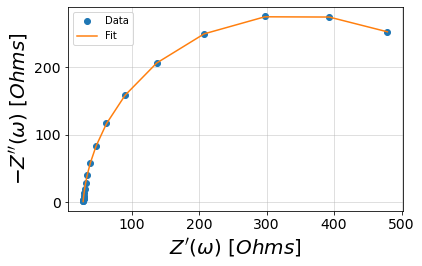

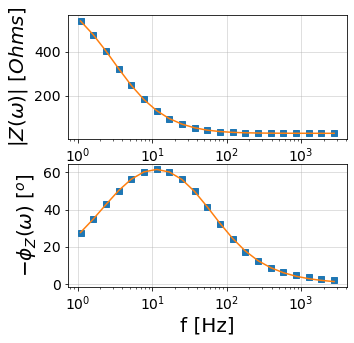


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.82e+01  (+/- 1.12e-01) [Ohm]
     R1 = 1.90e+02  (+/- 1.14e+02) [Ohm]
  CPE1_0 = 1.23e-03  (+/- 8.12e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.36e-01  (+/- 1.29e-01) []
     R2 = 4.78e+02  (+/- 1.01e+02) [Ohm]
  CPE2_0 = 1.55e-04  (+/- 1.66e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.48e-01  (+/- 1.46e-02) []

Fitting error of parameter #1 at 60.2%
Fitting error of parameter #2 at 66.2%
Fitting error of parameter #3 at 13.8%
Fitting error of parameter #4 at 21.1%
Fitting error of parameter #5 at 10.7%


Result of Cycle 19:


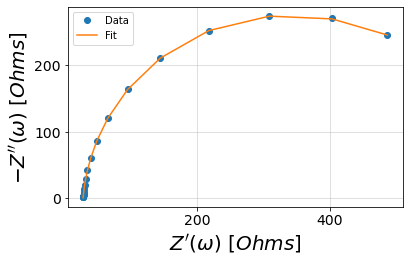

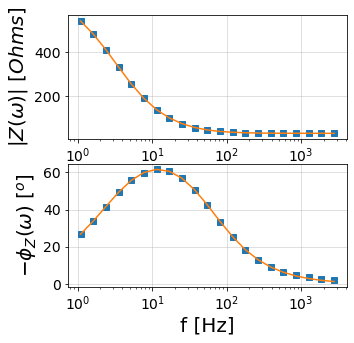


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.82e+01  (+/- 9.20e-02) [Ohm]
     R1 = 1.72e+02  (+/- 9.36e+01) [Ohm]
  CPE1_0 = 1.37e-03  (+/- 7.63e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.41e-01  (+/- 1.32e-01) []
     R2 = 4.91e+02  (+/- 8.01e+01) [Ohm]
  CPE2_0 = 1.46e-04  (+/- 1.18e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.47e-01  (+/- 1.14e-02) []

Fitting error of parameter #1 at 54.4%
Fitting error of parameter #2 at 55.8%
Fitting error of parameter #3 at 14.0%
Fitting error of parameter #4 at 16.3%


Result of Cycle 20:


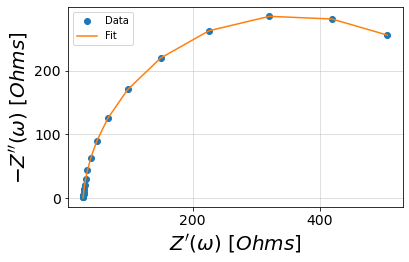

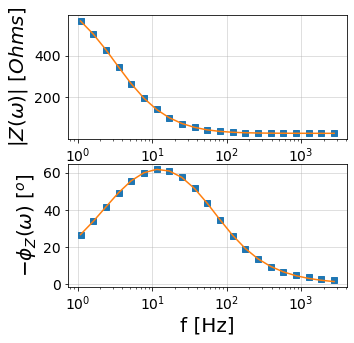


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 1.09e-01) [Ohm]
     R1 = 1.86e+02  (+/- 1.09e+02) [Ohm]
  CPE1_0 = 1.23e-03  (+/- 7.73e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.37e-01  (+/- 1.32e-01) []
     R2 = 5.05e+02  (+/- 9.53e+01) [Ohm]
  CPE2_0 = 1.42e-04  (+/- 1.33e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.47e-01  (+/- 1.31e-02) []

Fitting error of parameter #1 at 58.8%
Fitting error of parameter #2 at 62.8%
Fitting error of parameter #3 at 14.1%
Fitting error of parameter #4 at 18.9%


Result of Cycle 21:


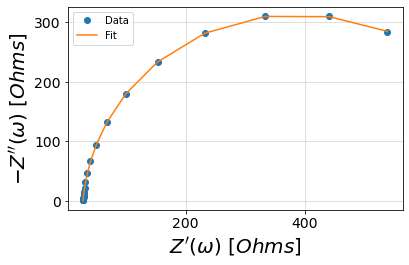

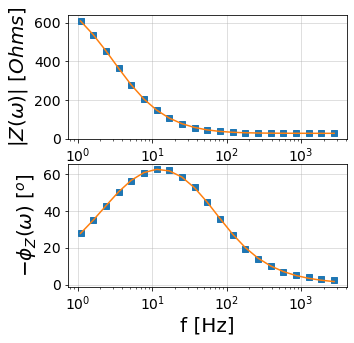


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 9.64e-02) [Ohm]
     R1 = 2.10e+02  (+/- 1.19e+02) [Ohm]
  CPE1_0 = 1.06e-03  (+/- 6.33e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.47e-01  (+/- 1.25e-01) []
     R2 = 5.41e+02  (+/- 1.04e+02) [Ohm]
  CPE2_0 = 1.37e-04  (+/- 1.38e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.46e-01  (+/- 1.20e-02) []

Fitting error of parameter #1 at 56.7%
Fitting error of parameter #2 at 59.6%
Fitting error of parameter #3 at 13.2%
Fitting error of parameter #4 at 19.3%
Fitting error of parameter #5 at 10.0%


Result of Cycle 22:


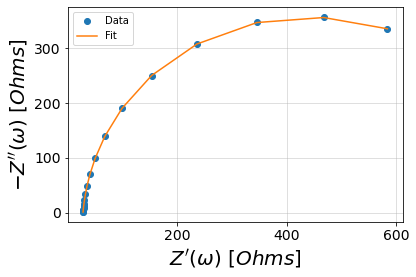

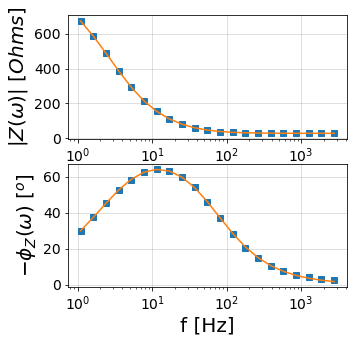


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 1.28e-01) [Ohm]
     R1 = 3.07e+02  (+/- 1.85e+02) [Ohm]
  CPE1_0 = 6.73e-04  (+/- 4.72e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.40e-01  (+/- 9.82e-02) []
     R2 = 5.48e+02  (+/- 1.71e+02) [Ohm]
  CPE2_0 = 1.41e-04  (+/- 2.44e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.47e-01  (+/- 1.78e-02) []

Fitting error of parameter #1 at 60.4%
Fitting error of parameter #2 at 70.2%
Fitting error of parameter #3 at 10.4%
Fitting error of parameter #4 at 31.2%
Fitting error of parameter #5 at 17.3%


Result of Cycle 23:


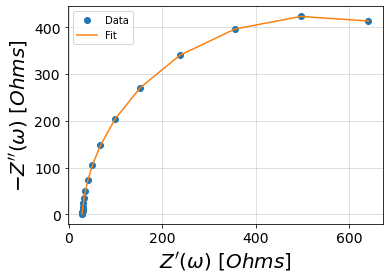

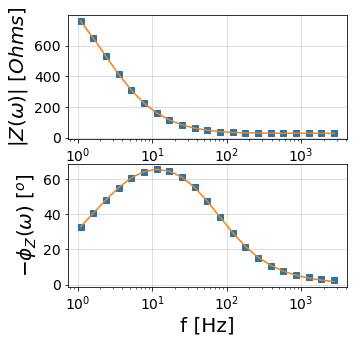


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 9.10e-02) [Ohm]
     R1 = 5.22e+02  (+/- 1.75e+02) [Ohm]
  CPE1_0 = 3.50e-04  (+/- 1.38e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.47e-01  (+/- 4.41e-02) []
     R2 = 4.80e+02  (+/- 1.65e+02) [Ohm]
  CPE2_0 = 1.60e-04  (+/- 3.26e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.48e-01  (+/- 1.64e-02) []

Fitting error of parameter #1 at 33.5%
Fitting error of parameter #2 at 39.5%
Fitting error of parameter #4 at 34.4%
Fitting error of parameter #5 at 20.4%


Result of Cycle 24:


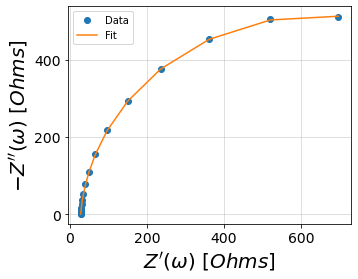

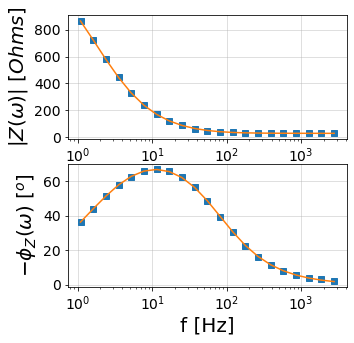


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.80e+01  (+/- 1.78e-01) [Ohm]
     R1 = 7.39e+02  (+/- 3.51e+02) [Ohm]
  CPE1_0 = 2.71e-04  (+/- 1.54e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.42e-01  (+/- 6.08e-02) []
     R2 = 4.79e+02  (+/- 3.31e+02) [Ohm]
  CPE2_0 = 1.74e-04  (+/- 7.20e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.47e-01  (+/- 3.40e-02) []

Fitting error of parameter #1 at 47.4%
Fitting error of parameter #2 at 56.9%
Fitting error of parameter #4 at 69.2%
Fitting error of parameter #5 at 41.3%


Result of Cycle 25:


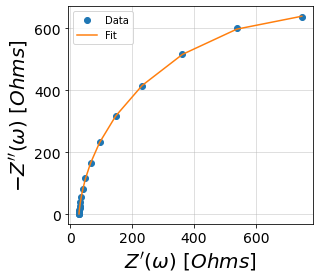

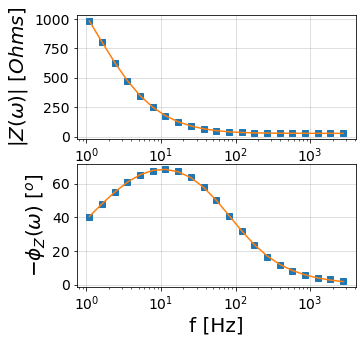


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.80e+01  (+/- 1.90e-01) [Ohm]
     R1 = 1.01e+03  (+/- 4.27e+02) [Ohm]
  CPE1_0 = 2.25e-04  (+/- 1.10e-04) [Ohm^-1 sec^a]
  CPE1_1 = 9.47e-01  (+/- 6.55e-02) []
     R2 = 5.00e+02  (+/- 3.95e+02) [Ohm]
  CPE2_0 = 1.84e-04  (+/- 8.61e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.43e-01  (+/- 3.90e-02) []

Fitting error of parameter #1 at 42.1%
Fitting error of parameter #2 at 49.1%
Fitting error of parameter #4 at 79.1%
Fitting error of parameter #5 at 46.9%


Result of Cycle 26:


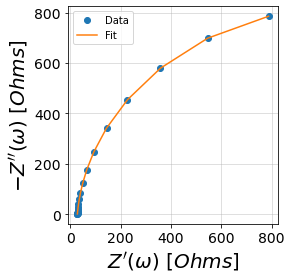

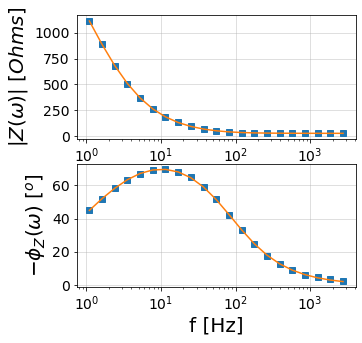


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 1.13e-01) [Ohm]
     R1 = 1.33e+03  (+/- 3.03e+02) [Ohm]
  CPE1_0 = 1.92e-04  (+/- 4.49e-05) [Ohm^-1 sec^a]
  CPE1_1 = 9.66e-01  (+/- 4.83e-02) []
     R2 = 5.51e+02  (+/- 2.65e+02) [Ohm]
  CPE2_0 = 1.86e-04  (+/- 5.47e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.29e-01  (+/- 1.94e-02) []

Fitting error of parameter #1 at 22.7%
Fitting error of parameter #2 at 23.3%
Fitting error of parameter #4 at 48.1%
Fitting error of parameter #5 at 29.4%


Result of Cycle 27:


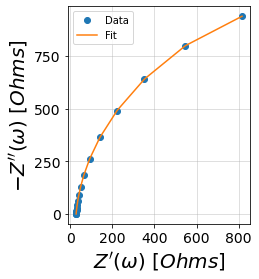

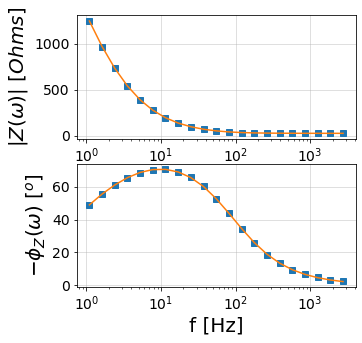


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.82e+01  (+/- 1.77e-01) [Ohm]
     R1 = 1.99e+03  (+/- 3.29e+02) [Ohm]
  CPE1_0 = 1.41e-04  (+/- 2.29e-05) [Ohm^-1 sec^a]
  CPE1_1 = 9.51e-01  (+/- 4.29e-02) []
     R2 = 3.57e+02  (+/- 2.75e+02) [Ohm]
  CPE2_0 = 2.55e-04  (+/- 1.06e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.34e-01  (+/- 4.56e-02) []

Fitting error of parameter #1 at 16.6%
Fitting error of parameter #2 at 16.3%
Fitting error of parameter #4 at 77.1%
Fitting error of parameter #5 at 41.6%


Result of Cycle 28:


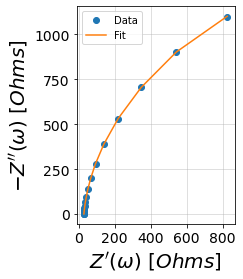

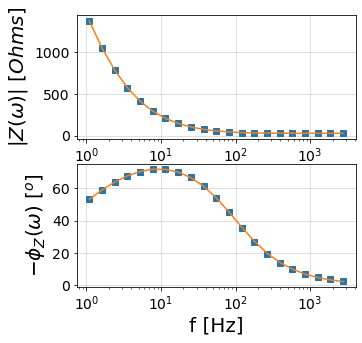


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.83e+01  (+/- 2.41e-01) [Ohm]
     R1 = 2.67e+03  (+/- 3.44e+02) [Ohm]
  CPE1_0 = 1.26e-04  (+/- 1.48e-05) [Ohm^-1 sec^a]
  CPE1_1 = 9.44e-01  (+/- 4.01e-02) []
     R2 = 3.30e+02  (+/- 2.67e+02) [Ohm]
  CPE2_0 = 2.82e-04  (+/- 1.15e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.34e-01  (+/- 5.76e-02) []

Fitting error of parameter #1 at 12.9%
Fitting error of parameter #2 at 11.7%
Fitting error of parameter #4 at 81.0%
Fitting error of parameter #5 at 40.7%


Result of Cycle 29:


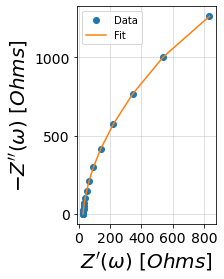

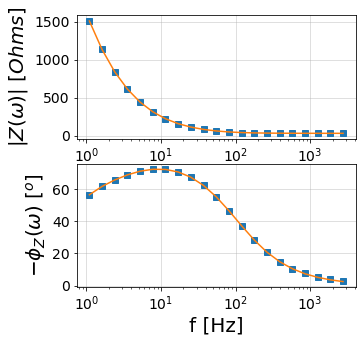


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.88e+01  (+/- 5.28e-02) [Ohm]
     R1 = 3.43e+03  (+/- 5.66e+01) [Ohm]
  CPE1_0 = 1.09e-04  (+/- 1.01e-06) [Ohm^-1 sec^a]
  CPE1_1 = 9.46e-01  (+/- 6.65e-03) []
     R2 = 2.47e+02  (+/- 3.51e+01) [Ohm]
  CPE2_0 = 3.14e-04  (+/- 1.95e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.36e-01  (+/- 1.21e-02) []

Fitting error of parameter #4 at 14.2%


Result of Cycle 30:


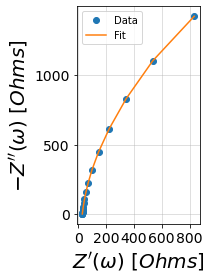

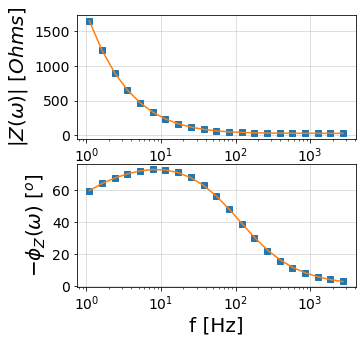


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.85e+01  (+/- 2.46e-01) [Ohm]
     R1 = 4.70e+03  (+/- 6.53e+01) [Ohm]
  CPE1_0 = 9.99e-05  (+/- 7.50e-07) [Ohm^-1 sec^a]
  CPE1_1 = 9.14e-01  (+/- 6.52e-03) []
     R2 = 1.22e+02  (+/- 3.43e+01) [Ohm]
  CPE2_0 = 4.54e-04  (+/- 3.51e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 4.10e-02) []

Fitting error of parameter #4 at 28.1%


Result of Cycle 31:


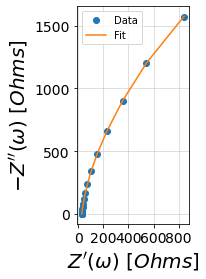

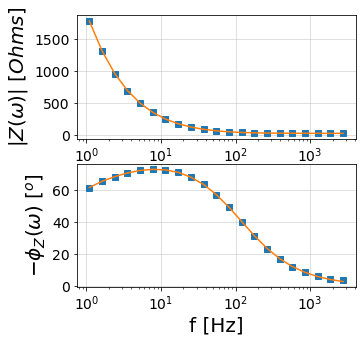


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.92e+01  (+/- 4.38e-01) [Ohm]
     R1 = 5.71e+03  (+/- 3.52e+02) [Ohm]
  CPE1_0 = 9.52e-05  (+/- 2.18e-06) [Ohm^-1 sec^a]
  CPE1_1 = 9.23e-01  (+/- 2.80e-02) []
     R2 = 2.02e+02  (+/- 1.65e+02) [Ohm]
  CPE2_0 = 3.89e-04  (+/- 1.20e-04) [Ohm^-1 sec^a]
  CPE2_1 = 9.37e-01  (+/- 8.77e-02) []

Fitting error of parameter #4 at 81.7%
Fitting error of parameter #5 at 30.7%


Result of Cycle 32:


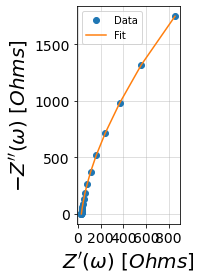

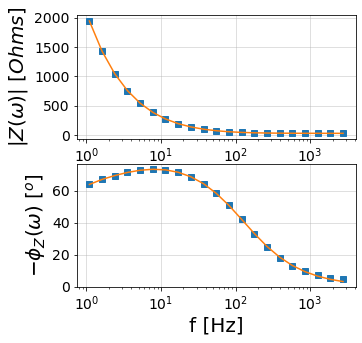


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.00e+01  (+/- 1.80e-01) [Ohm]
     R1 = 7.48e+03  (+/- 1.27e+02) [Ohm]
  CPE1_0 = 8.97e-05  (+/- 4.33e-07) [Ohm^-1 sec^a]
  CPE1_1 = 9.14e-01  (+/- 7.84e-03) []
     R2 = 2.09e+02  (+/- 4.78e+01) [Ohm]
  CPE2_0 = 3.67e-04  (+/- 2.86e-05) [Ohm^-1 sec^a]
  CPE2_1 = 9.44e-01  (+/- 2.76e-02) []

Fitting error of parameter #4 at 22.9%


Result of Cycle 33:


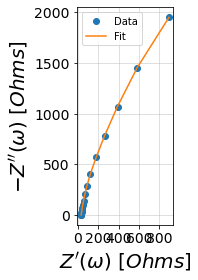

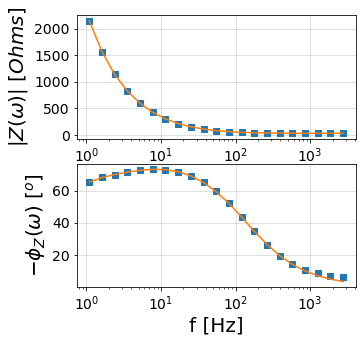


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.12e+01  (+/- 3.51e-01) [Ohm]
     R1 = 9.05e+03  (+/- 1.85e+02) [Ohm]
  CPE1_0 = 7.96e-05  (+/- 3.61e-07) [Ohm^-1 sec^a]
  CPE1_1 = 9.04e-01  (+/- 8.09e-03) []
     R2 = 1.11e+02  (+/- 3.35e+01) [Ohm]
  CPE2_0 = 3.77e-04  (+/- 2.25e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 5.12e-02) []

Fitting error of parameter #4 at 30.2%


Result of Cycle 34:


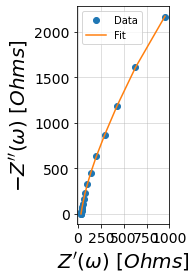

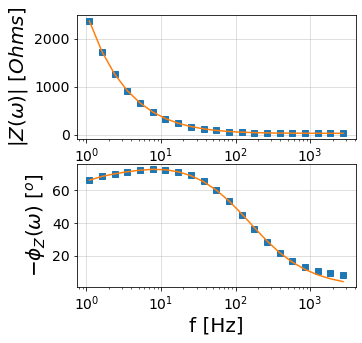


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 6.69e-01) [Ohm]
     R1 = 1.19e+04  (+/- 3.75e+02) [Ohm]
  CPE1_0 = 7.47e-05  (+/- 5.20e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.89e-01  (+/- 1.15e-02) []
     R2 = 1.14e+02  (+/- 5.50e+01) [Ohm]
  CPE2_0 = 3.88e-04  (+/- 3.73e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 8.63e-02) []

Fitting error of parameter #4 at 48.4%


Result of Cycle 35:


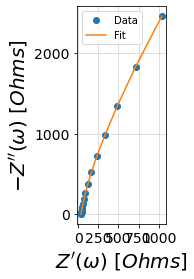

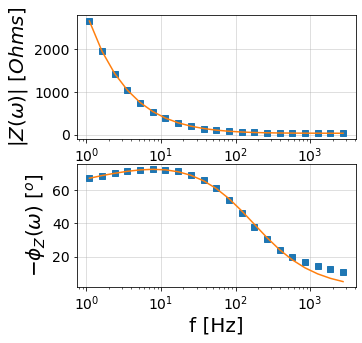


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.39e+01  (+/- 7.66e-01) [Ohm]
     R1 = 1.22e+04  (+/- 1.61e+03) [Ohm]
  CPE1_0 = 6.94e-05  (+/- 1.00e-06) [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00  (+/- 4.77e-02) []
     R2 = 1.14e+03  (+/- 3.64e+02) [Ohm]
  CPE2_0 = 1.50e-04  (+/- 3.17e-05) [Ohm^-1 sec^a]
  CPE2_1 = 8.17e-01  (+/- 4.18e-03) []

Fitting error of parameter #1 at 13.2%
Fitting error of parameter #4 at 31.8%
Fitting error of parameter #5 at 21.2%


Result of Cycle 36:


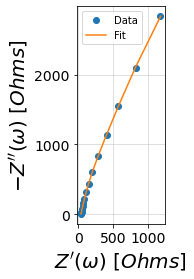

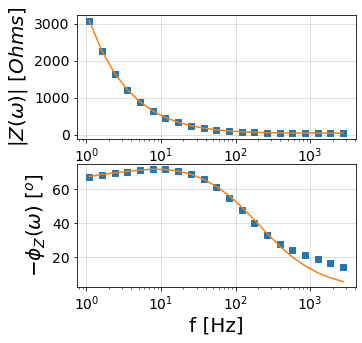


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.66e+01  (+/- 1.09e+00) [Ohm]
     R1 = 2.29e+04  (+/- 9.95e+02) [Ohm]
  CPE1_0 = 6.16e-05  (+/- 5.52e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.61e-01  (+/- 1.12e-02) []
     R2 = 1.46e+02  (+/- 6.71e+01) [Ohm]
  CPE2_0 = 2.92e-04  (+/- 2.60e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 9.01e-02) []

Fitting error of parameter #4 at 45.8%


Result of Cycle 37:


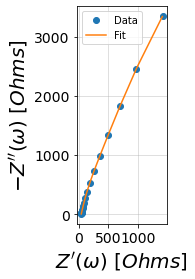

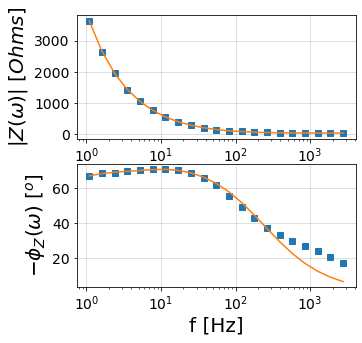


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.97e+01  (+/- 2.08e+00) [Ohm]
     R1 = 2.72e+04  (+/- 2.57e+03) [Ohm]
  CPE1_0 = 5.24e-05  (+/- 1.17e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.52e-01  (+/- 2.07e-02) []
     R2 = 1.32e+02  (+/- 1.12e+02) [Ohm]
  CPE2_0 = 2.36e-04  (+/- 3.77e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 1.74e-01) []

Fitting error of parameter #4 at 84.9%
Fitting error of parameter #5 at 16.0%
Fitting error of parameter #6 at 17.4%


Result of Cycle 38:


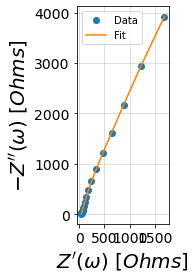

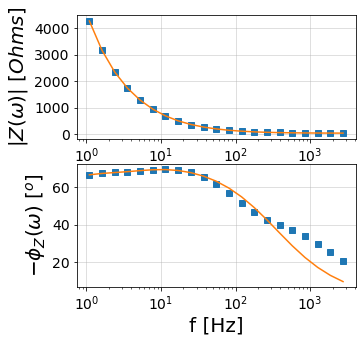


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.94e+01  (+/- 2.49e+00) [Ohm]
     R1 = 4.84e+04  (+/- 4.18e+03) [Ohm]
  CPE1_0 = 4.81e-05  (+/- 6.63e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.18e-01  (+/- 1.37e-02) []
     R2 = 1.57e+02  (+/- 1.06e+02) [Ohm]
  CPE2_0 = 2.35e-04  (+/- 3.54e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 1.49e-01) []

Fitting error of parameter #4 at 67.5%
Fitting error of parameter #5 at 15.1%
Fitting error of parameter #6 at 14.9%


Result of Cycle 39:


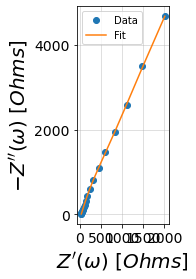

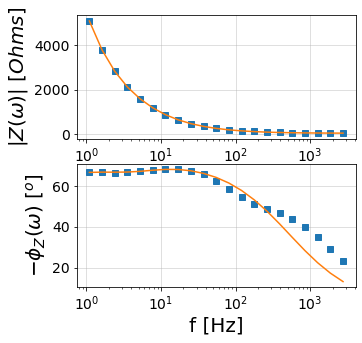


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.87e+01  (+/- 3.10e+00) [Ohm]
     R1 = 1.00e+05  (+/- 1.72e+04) [Ohm]
  CPE1_0 = 4.26e-05  (+/- 7.57e-07) [Ohm^-1 sec^a]
  CPE1_1 = 7.96e-01  (+/- 1.41e-02) []
     R2 = 1.95e+02  (+/- 1.06e+02) [Ohm]
  CPE2_0 = 1.50e-04  (+/- 2.18e-05) [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00  (+/- 1.28e-01) []

Fitting error of parameter #1 at 17.2%
Fitting error of parameter #4 at 54.4%
Fitting error of parameter #5 at 14.5%
Fitting error of parameter #6 at 12.8%


Result of Cycle 40:


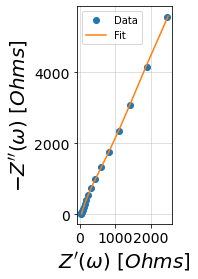

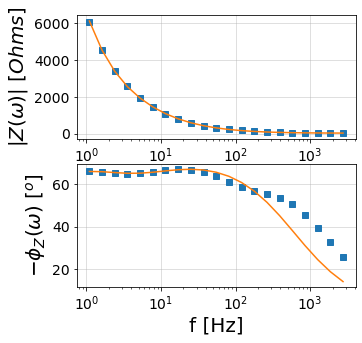


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 4.30e+01  (+/- 5.04e+00) [Ohm]
     R1 = 5.61e+04  (+/- 1.58e+04) [Ohm]
  CPE1_0 = 3.22e-05  (+/- 1.70e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.74e-01  (+/- 4.79e-02) []
     R2 = 9.32e+02  (+/- 4.72e+02) [Ohm]
  CPE2_0 = 6.90e-05  (+/- 9.38e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.01e-01  (+/- 4.93e-02) []

Fitting error of parameter #0 at 11.7%
Fitting error of parameter #1 at 28.2%
Fitting error of parameter #4 at 50.6%
Fitting error of parameter #5 at 13.6%


Result of Cycle 41:


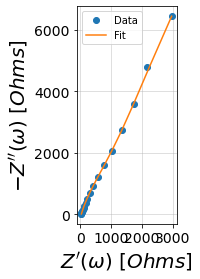

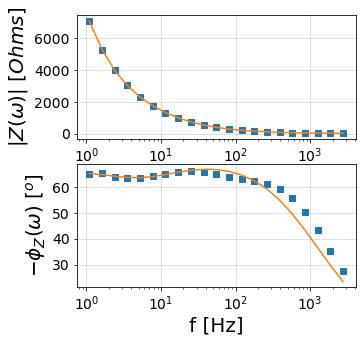


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.15e+01  (+/- 5.86e+00) [Ohm]
     R1 = 8.35e+04  (+/- 2.89e+04) [Ohm]
  CPE1_0 = 2.92e-05  (+/- 1.57e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.45e-01  (+/- 4.39e-02) []
     R2 = 9.85e+02  (+/- 4.64e+02) [Ohm]
  CPE2_0 = 5.60e-05  (+/- 6.26e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.00e-01  (+/- 5.38e-02) []

Fitting error of parameter #0 at 18.6%
Fitting error of parameter #1 at 34.6%
Fitting error of parameter #4 at 47.1%
Fitting error of parameter #5 at 11.2%


Result of Cycle 42:


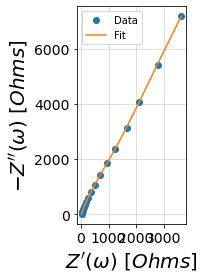

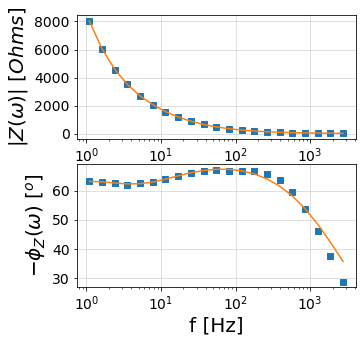


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.14e+01  (+/- 2.98e+00) [Ohm]
     R1 = 8.92e+04  (+/- 1.44e+04) [Ohm]
  CPE1_0 = 2.70e-05  (+/- 6.99e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.18e-01  (+/- 2.16e-02) []
     R2 = 1.05e+03  (+/- 2.61e+02) [Ohm]
  CPE2_0 = 4.95e-05  (+/- 2.64e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.00e-01  (+/- 2.99e-02) []

Fitting error of parameter #0 at 13.9%
Fitting error of parameter #1 at 16.2%
Fitting error of parameter #4 at 24.8%


Result of Cycle 43:


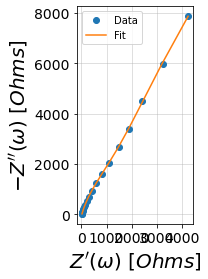

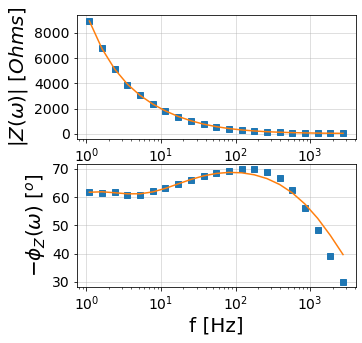


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 5.94e+00) [Ohm]
     R1 = 6.79e+04  (+/- 1.08e+04) [Ohm]
  CPE1_0 = 2.34e-05  (+/- 8.30e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.31e-01  (+/- 2.82e-02) []
     R2 = 1.23e+03  (+/- 3.41e+02) [Ohm]
  CPE2_0 = 3.31e-05  (+/- 2.45e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.25e-01  (+/- 3.94e-02) []

Fitting error of parameter #0 at 29.7%
Fitting error of parameter #1 at 16.0%
Fitting error of parameter #4 at 27.8%


Result of Cycle 44:


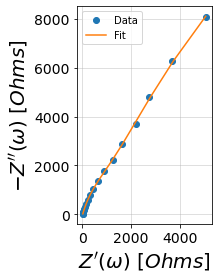

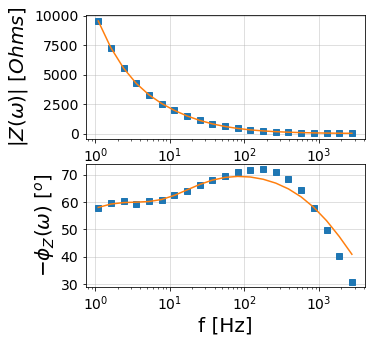


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 5.79e+00) [Ohm]
     R1 = 5.35e+04  (+/- 4.92e+03) [Ohm]
  CPE1_0 = 2.23e-05  (+/- 6.05e-07) [Ohm^-1 sec^a]
  CPE1_1 = 7.90e-01  (+/- 1.98e-02) []
     R2 = 7.64e+02  (+/- 2.17e+02) [Ohm]
  CPE2_0 = 2.58e-05  (+/- 3.09e-06) [Ohm^-1 sec^a]
  CPE2_1 = 9.26e-01  (+/- 6.04e-02) []

Fitting error of parameter #0 at 29.0%
Fitting error of parameter #4 at 28.4%
Fitting error of parameter #5 at 12.0%


Result of Cycle 45:


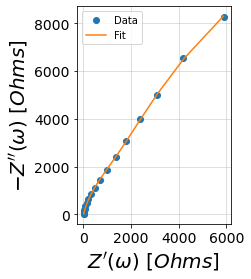

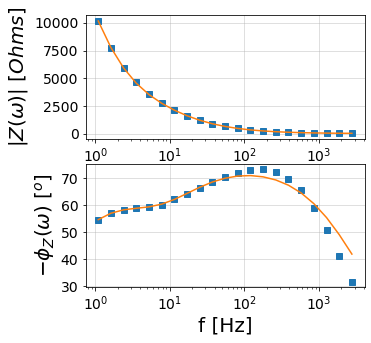


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 6.36e+00) [Ohm]
     R1 = 3.37e+04  (+/- 1.83e+03) [Ohm]
  CPE1_0 = 1.88e-05  (+/- 3.76e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.42e-01  (+/- 1.84e-02) []
     R2 = 1.23e+03  (+/- 2.40e+02) [Ohm]
  CPE2_0 = 2.13e-05  (+/- 1.74e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.76e-01  (+/- 3.43e-02) []

Fitting error of parameter #0 at 31.8%
Fitting error of parameter #4 at 19.4%


Result of Cycle 46:


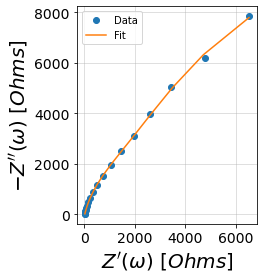

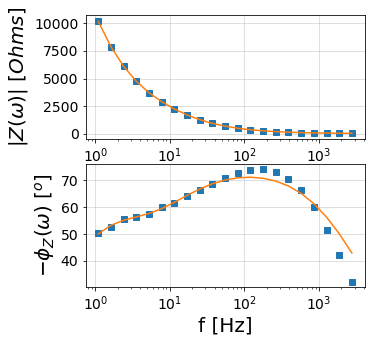


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 1.08e+01) [Ohm]
     R1 = 2.40e+04  (+/- 1.98e+03) [Ohm]
  CPE1_0 = 1.80e-05  (+/- 4.28e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.78e-01  (+/- 3.47e-02) []
     R2 = 1.96e+03  (+/- 5.47e+02) [Ohm]
  CPE2_0 = 1.92e-05  (+/- 1.68e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.43e-01  (+/- 3.68e-02) []

Fitting error of parameter #0 at 53.9%
Fitting error of parameter #4 at 27.9%


Result of Cycle 47:


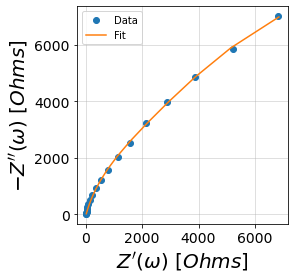

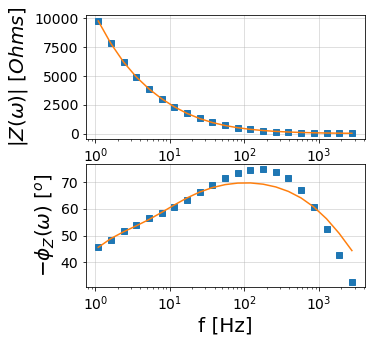


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 9.39e+00) [Ohm]
     R1 = 2.22e+04  (+/- 3.41e+03) [Ohm]
  CPE1_0 = 2.07e-05  (+/- 4.97e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.21e-01  (+/- 6.66e-02) []
     R2 = 2.04e+03  (+/- 1.30e+03) [Ohm]
  CPE2_0 = 2.22e-05  (+/- 3.04e-06) [Ohm^-1 sec^a]
  CPE2_1 = 8.45e-01  (+/- 7.35e-02) []

Fitting error of parameter #0 at 46.9%
Fitting error of parameter #1 at 15.3%
Fitting error of parameter #4 at 63.8%
Fitting error of parameter #5 at 13.7%


Result of Cycle 48:


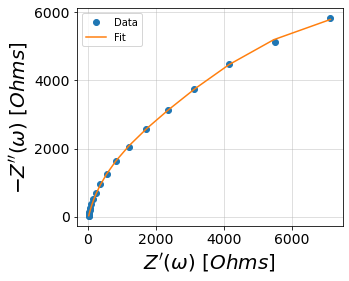

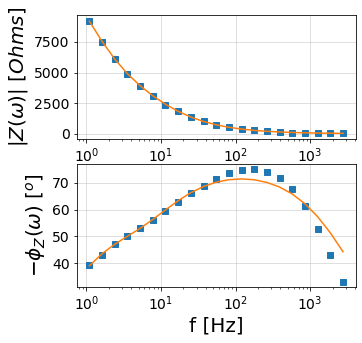


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 6.27e+00) [Ohm]
     R1 = 1.48e+04  (+/- 1.10e+03) [Ohm]
  CPE1_0 = 1.98e-05  (+/- 4.57e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.46e-01  (+/- 3.25e-02) []
     R2 = 2.17e+03  (+/- 5.89e+02) [Ohm]
  CPE2_0 = 1.63e-05  (+/- 9.66e-07) [Ohm^-1 sec^a]
  CPE2_1 = 8.68e-01  (+/- 3.20e-02) []

Fitting error of parameter #0 at 31.3%
Fitting error of parameter #4 at 27.1%


Result of Cycle 49:


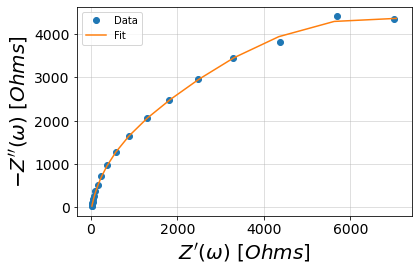

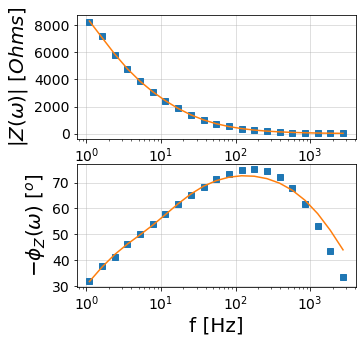


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []
     R2 = 1.00e+02 [Ohm]
  CPE2_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE2_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 1.26e+01) [Ohm]
     R1 = 1.04e+04  (+/- 1.27e+03) [Ohm]
  CPE1_0 = 1.81e-05  (+/- 1.17e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.55e-01  (+/- 4.95e-02) []
     R2 = 1.81e+03  (+/- 8.70e+02) [Ohm]
  CPE2_0 = 1.34e-05  (+/- 1.55e-06) [Ohm^-1 sec^a]
  CPE2_1 = 9.00e-01  (+/- 6.30e-02) []

Fitting error of parameter #0 at 62.8%
Fitting error of parameter #1 at 12.2%
Fitting error of parameter #4 at 47.9%
Fitting error of parameter #5 at 11.6%




<IPython.core.display.Javascript object>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist
import pandas as pd
from IPython.core.debugger import set_trace

%notify -m "The fitting has been started!"
for i in range(cycle_start, cycle_end):
    print("Result of Cycle \033[1m" + str(i) + "\033[0m:")
    Z_i = Z[i][cutoff_start:-cutoff_end]
    frequency_i = frequencies[i][cutoff_start:-cutoff_end]
    model_circuit.fit(frequency_i, Z_i, bounds=model_circuit_bounds)
    Z_fit = model_circuit.predict(frequency_i)
    fig, ax = plt.subplots()
    plot_nyquist(ax, Z_i, fmt='o')
    plot_nyquist(ax, Z_fit, fmt='-')
    plt.legend(['Data', 'Fit'])
    plt.show()
    model_circuit.plot(f_data=frequency_i, Z_data=Z_i, kind='bode')
    plt.show()
    print(model_circuit)
    errorlist = [0]
    for j in range(len(model_circuit.parameters_)):
        relerror = model_circuit.conf_[j]/model_circuit.parameters_[j]
        errorlist.append(relerror)
        if relerror > 0.1:
            print("Fitting error of parameter #" + str(j) + " at " + str(round(100*relerror, 1)) + "%")
    results.append(model_circuit.parameters_.tolist() + model_circuit.conf_.tolist() + errorlist[1:])
    print("\n")
%notify -m "The fitting has been completed!"

## Wrap data into dataframe and save dataframe as Excel file

In [10]:
names, units = model_circuit.get_param_names()
df = pd.DataFrame(data=results, columns=[names + ["Error of " + x for x in names] + ["Rel. Error of " + x for x in names]])

In [11]:
print(df)

           R0             R1    CPE1_0    CPE1_1             R2    CPE2_0  \
0   30.000000    1000.000000  0.000010  1.000000     100.000000  0.000001   
1   26.431661   60838.208300  0.001316  0.865915   17854.444915  0.001821   
2   26.017688   61735.587032  0.001438  0.854764   17812.893078  0.001708   
3   26.017616   61484.506616  0.001384  0.858296   17920.016890  0.001725   
4   29.246935   18301.366455  0.000815  0.933903  286954.978808  0.002958   
5   29.479729   99999.999998  0.000692  0.938804     227.107117  0.002447   
6   29.422420    8195.437307  0.000531  1.000000     288.216647  0.002042   
7   29.363161   14773.892837  0.000505  1.000000     560.085395  0.001063   
8   29.236010     699.435001  0.000689  0.895676   14429.997132  0.000458   
9   29.006113    5735.808444  0.000343  0.927292     275.318635  0.000821   
10  28.840048    2632.189636  0.000479  1.000000     797.237270  0.000351   
11  28.733516    1232.300998  0.000503  1.000000     696.791920  0.000299   

In [12]:
#Add voltage steps to the dataframe as first two columns
df.insert(loc = 0, column = "V vs. Ag/AgCl (mV)", value = ["(initial guess)"] + potentials_Ag[cycle_start:cycle_end])
df.insert(loc = 1, column = "V vs. RHE (mV)", value = ["(initial guess)"] + [x+197+59*pot_pH for x in potentials_Ag][cycle_start:cycle_end])

Optional: Calculate real capacitance based on CPE and R values using  C = ( CPE-T * R )(1/CPE-P) / R

In [13]:
if model == "1RCPE":
    df.insert(loc = len(df.columns), column = "C_1 (calculated)", value = [pow((df.loc[i]["CPE1_0"]*df.loc[i]["R1"]), 1/df.loc[i]["CPE1_1"])/df.loc[i]["R1"] for i in range(df.shape[0])])

In [14]:
# Create file directory for the analysis
import os
if not os.path.exists(filename):
    os.makedirs(filename)

In [15]:
# Output to excel
savefile = model + "-Analysis-wBounds_" + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + " - " + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + "mV of " + filename
df.to_excel("./" + filename + "//" + savefile + ".xlsx")

In [19]:
# Save notebook output as HTML
os.system('jupyter nbconvert --to html --output "./' + filename + '//' + savefile + '" "SPEIS automated analysis.ipynb"')

0

## Post-analysis and embedded data treatment

In [17]:
%matplotlib notebook
import mplcursors
# Create plot for calculated capacitance
fig, ax = plt.subplots()

labels = ["a", "b", "c", "d", "e"]
x = df[1:]["V vs. Ag/AgCl (mV)"].values
y = df[1:]["C_1 (calculated)"].values
sum_error = df[1:]["Rel. Error of CPE1_0"].values.flatten() + df[1:]["Rel. Error of R1"].values.flatten() + df[1:]["Rel. Error of CPE1_1"].values.flatten() / 3
y_error = np.multiply(df[1:]["C_1 (calculated)"].values.flatten(), sum_error)

plt.scatter(x, y)
ax.errorbar(x, y, yerr = y_error, linestyle="None")
plt.ylabel("Capacitance (F)")
plt.xlabel("V vs RHE")
plt.ylim(min(y)*0.9, max(y)*1.1)
fig.set_size_inches(13,8)
plt.title("C1 vs. Potential (V vs. RHE)")
for i in range(df.index[0], df.index[-1]):
    ax.annotate(i+1, (x[i], y[i]))
plt.ion()
plt.show()

<IPython.core.display.Javascript object>

KeyError: 'C_1 (calculated)'

In [ ]:
print("Which cycle do you want to fit again?")
inspec_cycle_no = int(input())

model_circuit = CustomCircuit(model_circuit.circuit, initial_guess=model_circuit.initial_guess)
model_circuit.parameters_ = df.iloc[inspec_cycle_no][2:2+len(model_circuit.initial_guess)].values
model_circuit.conf_ = df.iloc[inspec_cycle_no][len(model_circuit.initial_guess)+2:2+2*len(model_circuit.initial_guess)].values
model_circuit.plot(f_data=frequencies[inspec_cycle_no-1][cutoff_start:-cutoff_end], Z_data=Z[inspec_cycle_no-1][cutoff_start:-cutoff_end], kind="bode")

print(model_circuit)
